In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
import utils

2025-12-03 15:19:43.865682: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 15:19:43.919383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 15:19:45.593906: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_files = ["historical", "ssp126", "ssp370", 'hist-aer', 'hist-GHG']
tasFiles = ["historical", "ssp126", "ssp370", "hist-aer", "hist-GHG"]
# Create training and testing arrays
X, solvers = utils.create_predictor_data(train_files)
Y = utils.create_predictdand_data(tasFiles)

In [3]:
# Compute latitude-based cosine weighting for area-weighted global means
weights = np.cos(np.deg2rad(Y.lat))
# Compute the globally averaged temperature time series
# (weighted by latitude and averaged over all grid cells)
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

In [4]:
def fit_ps_model(global_ts, Y, model_type="ridge", alpha=0.8):
    
    """
    Fit a pattern-scaling model for CMIP-like climate outputs.
    
    Pattern scaling assumes that each spatial climate field (tas, pr, dtr, pr90)
    can be approximated as a linear response to a single global mean temperature
    time series
    """
    
    if model_type == "linear":
        make_model = lambda: LinearRegression(fit_intercept=False)
    elif model_type == "ridge":
        make_model = lambda: Ridge(alpha=alpha, fit_intercept=False)
    else:
        make_model = lambda: Lasso(alpha=alpha, fit_intercept=False)

    # Prepare outputs Y stacked into (time, n_grid)
    tas = Y["tas"].stack(points=("lat", "lon"))
    pr = Y["pr"].stack(points=("lat", "lon"))
    dtr = Y["diurnal_temperature_range"].stack(points=("lat", "lon"))
    pr90 = Y["pr90"].stack(points=("lat", "lon"))
    a = global_ts.to_numpy().reshape(-1, 1)

    models = {}
    models["tas"] = make_model().fit(a, tas)
    models["pr"]  = make_model().fit(a, pr)
    models["dtr"]  = make_model().fit(a, dtr)
    models["pr90"] = make_model().fit(a, pr90)

    return models

# try with different methods (linear/lasso/ridge regression)
model_linear = fit_ps_model(global_mean_temp, Y, model_type="linear", alpha=67)
model_ridge = fit_ps_model(global_mean_temp, Y, model_type="ridge", alpha=1.2)
model_lasso = fit_ps_model(global_mean_temp, Y, model_type="lasso", alpha=2)

In [6]:
# Test on SSP245
test_X = utils.get_test_data('ssp245', solvers)
test_Y = utils.create_predictdand_data(['ssp245'])

tas_truth = test_Y["tas"]
pr_truth = test_Y["pr"]
pr90_truth = test_Y["pr90"]
dtr_truth = test_Y["diurnal_temperature_range"]

# Smooth out the internal variability otherwise it's cheating (remove noise from data)
test_inputs = test_Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()

In [14]:
def predicting(model, test_inputs):
    """
    Use fitted pattern-scaling models to generate spatial climate projections
    and compute evaluation metrics (spatial NRMSE, global NRMSE, total NRMSE)
    for TAS, PR, PR90, and DTR.
    """
    m_out_t = model["tas"].predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_p = model["pr"].predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_d = model["dtr"].predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_p90 = model["pr90"].predict(test_inputs.to_numpy()[:, np.newaxis])

    # Reshape model outputs back into map form (time, lat, lon)
    m_out_tas = m_out_t.reshape(86, 96, 144)
    m_out_pr = m_out_p.reshape(86, 96, 144)
    m_out_pr90 = m_out_p90.reshape(86, 96, 144)
    m_out_dtr = m_out_d.reshape(86, 96, 144)

    # Create an xarray Dataset to store the emulated climate fields
    # using the correct time, latitude, and longitude coordinates
    xr_output=xr.Dataset(coords={'time': test_Y.time.values, 'lat': test_Y.lat.values, 'lon': test_Y.lon.values}) 
    xr_output["tas"]=(['time', 'lat', 'lon'], m_out_tas) 
    xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'], m_out_dtr) 
    xr_output["pr"]=(['time', 'lat', 'lon'], m_out_pr) 
    xr_output["pr90"]=(['time', 'lat', 'lon'], m_out_pr90)

    print(f"TAS NRMSE_SPATIAL: {utils.nrmse_spatial(tas_truth[:65], xr_output['tas'][:65]).mean()}")
    print(f"TAS NRMSE_GLOBAL: {utils.nrmse_global(tas_truth[:65], xr_output['tas'][:65]).mean()}")
    print(f"TAS NRMSE_TOTAL: {utils.nrmse_total(tas_truth[:65], xr_output['tas'][:65]).mean()}\n")
    
    print(f"PR NRMSE_SPATIAL: {utils.nrmse_spatial(pr_truth[:65], xr_output['pr'][:65]).mean()}")
    print(f"PR NRMSE_GLOBAL: {utils.nrmse_global(pr_truth[:65], xr_output['pr'][:65]).mean()}")
    print(f"PR NRMSE_TOTAL: {utils.nrmse_total(pr_truth[:65], xr_output['pr'][:65]).mean()}\n")
    
    print(f"PR90 NRMSE_SPATIAL: {utils.nrmse_spatial(pr90_truth[:65], xr_output['pr90'][:65]).mean()}")
    print(f"PR90 NRMSE_GLOBAL: {utils.nrmse_global(pr90_truth[:65], xr_output['pr90'][:65]).mean()}")
    print(f"PR90 NRMSE_TOTAL: {utils.nrmse_total(pr90_truth[:65], xr_output['pr90'][:65]).mean()}\n")
    
    print(f"DTR NRMSE_SPATIAL: {utils.nrmse_spatial(dtr_truth[:65], xr_output['diurnal_temperature_range'][:65]).mean()}")
    print(f"DTR NRMSE_GLOBAL: {utils.nrmse_global(dtr_truth[:65], xr_output['diurnal_temperature_range'][:65]).mean()}")
    print(f"DTR NRMSE_TOTAL: {utils.nrmse_total(dtr_truth[:65], xr_output['diurnal_temperature_range'][:65]).mean()}\n")
    
    return

Linear Regression was generally the best we found

In [15]:
print("linear")
predicting(model_linear, test_inputs)
print("ridge")
predicting(model_ridge, test_inputs)
print("lasso")
predicting(model_lasso, test_inputs)

linear
TAS NRMSE_SPATIAL: 0.3081435112392221
TAS NRMSE_GLOBAL: 0.0631336117535584
TAS NRMSE_TOTAL: 0.623811570007014

PR NRMSE_SPATIAL: 60.662003984262654
PR NRMSE_GLOBAL: 2.247459307289246
PR NRMSE_TOTAL: 71.89930052070889

PR90 NRMSE_SPATIAL: 75.33728417745833
PR90 NRMSE_GLOBAL: 2.500064211233959
PR90 NRMSE_TOTAL: 87.8376052336281

DTR NRMSE_SPATIAL: 5.512628721608581
DTR NRMSE_GLOBAL: 0.6045471428659963
DTR NRMSE_TOTAL: 8.535364435938563

ridge
TAS NRMSE_SPATIAL: 0.3087879680333921
TAS NRMSE_GLOBAL: 0.0645094545436018
TAS NRMSE_TOTAL: 0.6313352407514011

PR NRMSE_SPATIAL: 60.66012309271327
PR NRMSE_GLOBAL: 2.2423091930854353
PR NRMSE_TOTAL: 71.87166905814044

PR90 NRMSE_SPATIAL: 75.33843451248218
PR90 NRMSE_GLOBAL: 2.4946308524654177
PR90 NRMSE_TOTAL: 87.81158877480927

DTR NRMSE_SPATIAL: 5.5137201235012165
DTR NRMSE_GLOBAL: 0.6043353461140748
DTR NRMSE_TOTAL: 8.53539685407159

lasso
TAS NRMSE_SPATIAL: 1.1801150263643436
TAS NRMSE_GLOBAL: 0.9872315753299452
TAS NRMSE_TOTAL: 6.116272

In [16]:
model = fit_ps_model(global_mean_temp, Y, model_type="linear", alpha=67)

m_out_t = model["tas"].predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p = model["pr"].predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_d = model["dtr"].predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p90 = model["pr90"].predict(test_inputs.to_numpy()[:, np.newaxis])

# puts back to map
m_out_tas = m_out_t.reshape(86, 96, 144)
m_out_pr = m_out_p.reshape(86, 96, 144)
m_out_pr90 = m_out_p90.reshape(86, 96, 144)
m_out_dtr = m_out_d.reshape(86, 96, 144)

In [19]:
# Create an xarray Dataset to store the emulated climate fields
# using the correct time, latitude, and longitude coordinates
xr_output=xr.Dataset(coords={'time': test_Y.time.values, 'lat': test_Y.lat.values, 'lon': test_Y.lon.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  m_out_tas)
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  m_out_dtr)
xr_output["pr"]=(['time', 'lat', 'lon'],  m_out_pr)
xr_output["pr90"]=(['time', 'lat', 'lon'],  m_out_pr90)

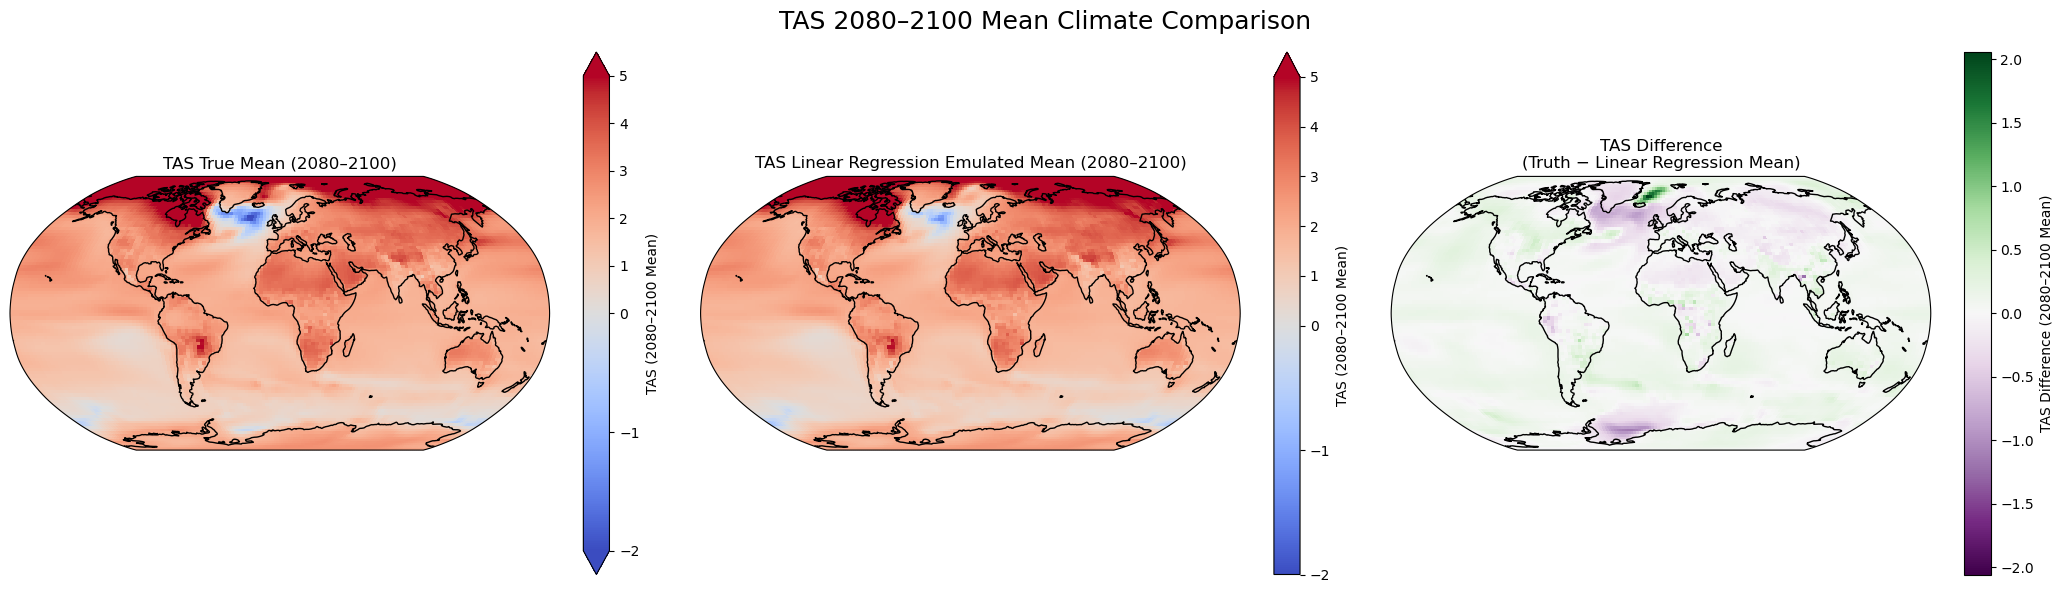

In [20]:
utils.plot_mean_2080_2100(tas_truth, xr_output["tas"], "TAS", savefig = True, Model = "Linear Regression")

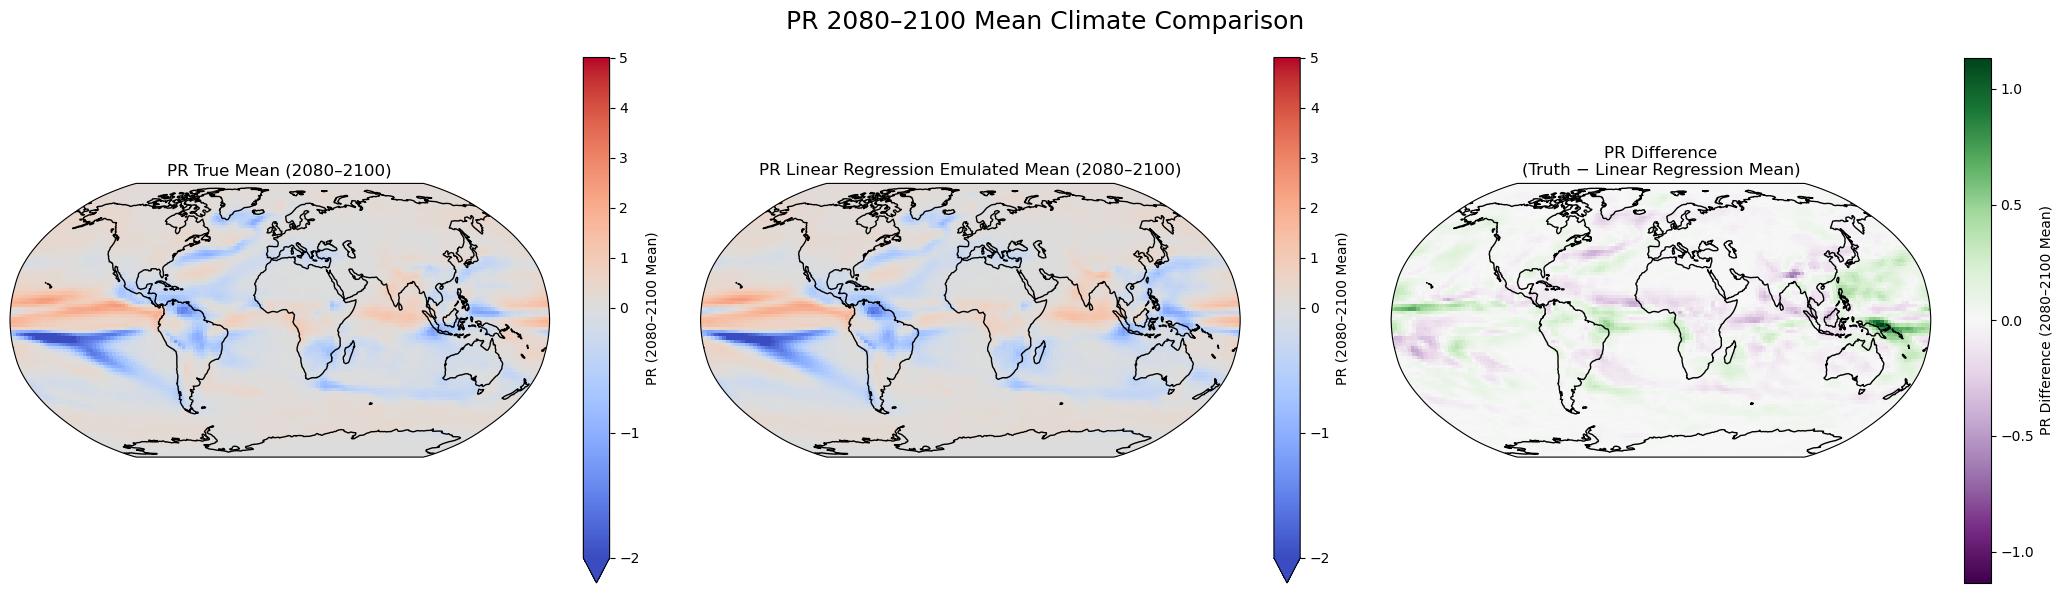

In [22]:
utils.plot_mean_2080_2100(pr_truth, xr_output["pr"], "PR", savefig = True, Model = "Linear Regression")

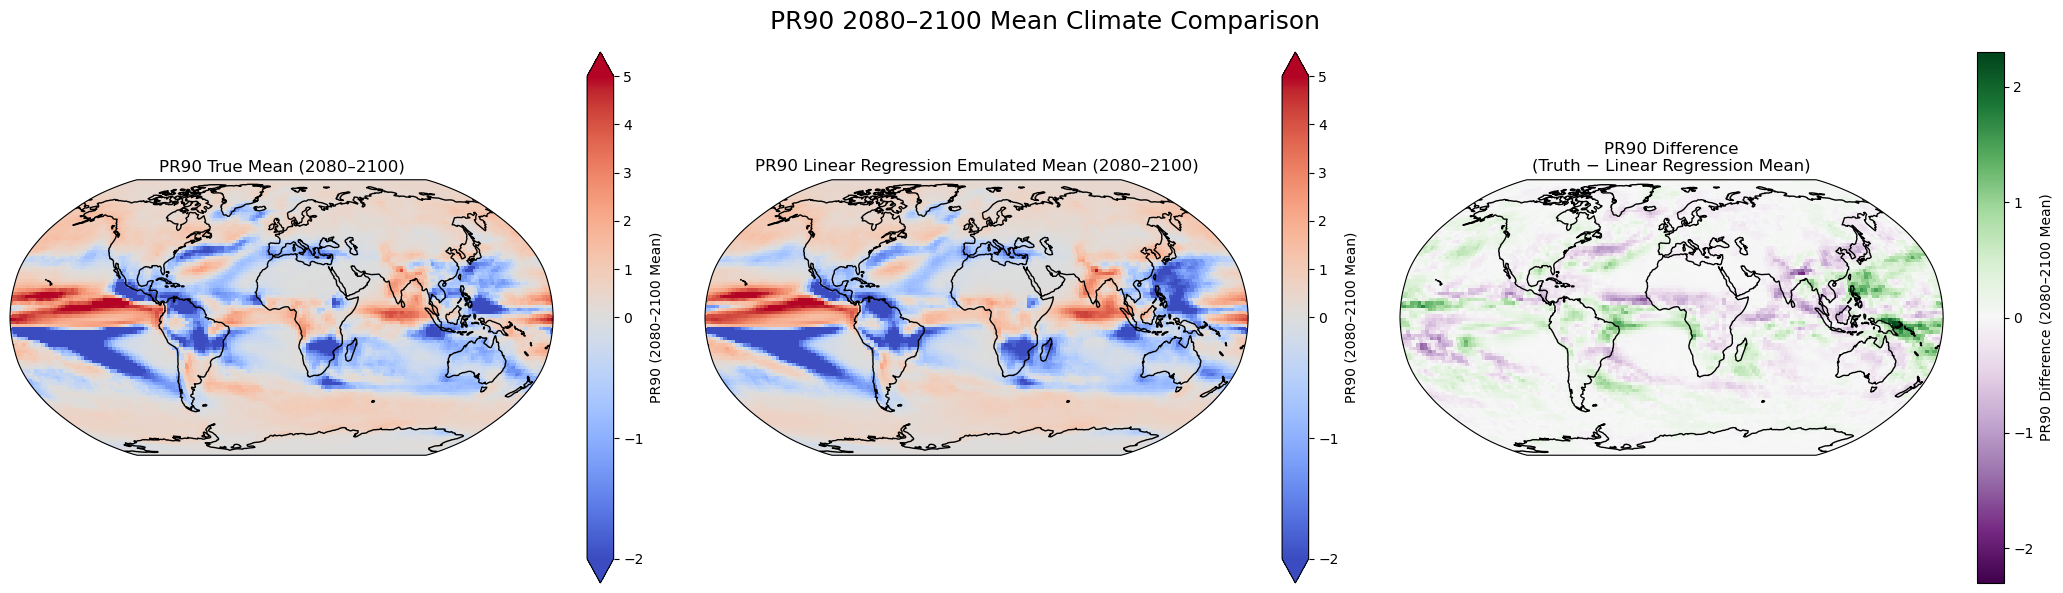

In [23]:
utils.plot_mean_2080_2100(pr90_truth, xr_output["pr90"], "PR90", savefig = True, Model = "Linear Regression")

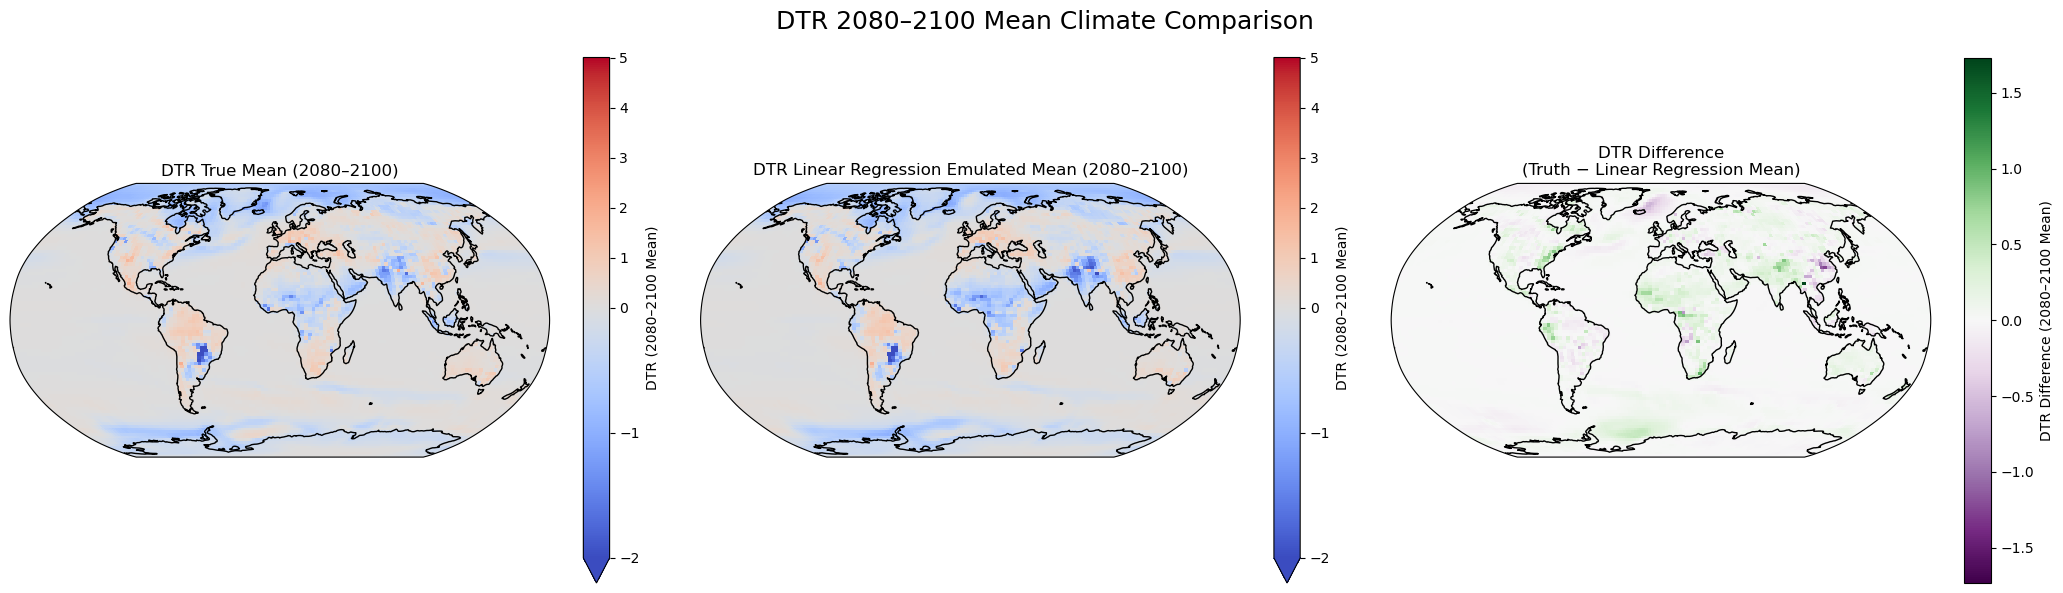

In [24]:
utils.plot_mean_2080_2100(dtr_truth, xr_output["diurnal_temperature_range"], "DTR", savefig = True, Model = "Linear Regression")